## 1. Import Library yang Diperlukan

Pada tahap awal, kita perlu mengimpor semua library yang akan digunakan dalam proses data wrangling. Library ini mencakup tools untuk manipulasi data, visualisasi, dan text processing.

In [24]:
# Library untuk manipulasi dan analisis data
import pandas as pd
import numpy as np

# Library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk text processing dan regular expressions
import re

# Library untuk machine learning dan split data
from sklearn.model_selection import train_test_split

# Library untuk deep learning dengan transformers
from transformers import AutoTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader

# Konfigurasi untuk tampilan yang lebih baik
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
sns.set_style("whitegrid")

print("Semua library berhasil diimpor.")

Semua library berhasil diimpor.


## 2. Load Dataset

Tahap pertama dalam data wrangling adalah memuat dataset dari sumber yang tersedia. Dataset ini diambil dari GitHub repository dalam format CSV.

In [25]:
# Memuat dataset dari URL GitHub
try:
    df = pd.read_csv('https://github.com/erlanggadewasakti/Prinsip-Sains-Data/releases/download/prod/sa-psd-dataset.csv')
    print(f"Dataset berhasil dimuat dengan {len(df)} baris data.")
    print(f"Jumlah kolom: {len(df.columns)}")
except FileNotFoundError:
    print("Error: File dataset tidak ditemukan. Pastikan URL sudah benar.")
except Exception as e:
    print(f"Terjadi error saat membaca file: {e}")

Dataset berhasil dimuat dengan 30000 baris data.
Jumlah kolom: 5


## 3. Inspeksi Awal Dataset

Sebelum melakukan cleaning, kita perlu memahami struktur dan karakteristik dataset. Ini termasuk melihat sample data, tipe data, dan informasi statistik dasar.

In [26]:
# Menampilkan 5 baris pertama dataset
print("=" * 80)
print("SAMPLE DATA (5 baris pertama)")
print("=" * 80)
display(df.head())

print("\n" + "=" * 80)
print("INFORMASI STRUKTUR DATASET")
print("=" * 80)
df.info()

print("\n" + "=" * 80)
print("STATISTIK DESKRIPTIF")
print("=" * 80)
display(df.describe(include='all'))

SAMPLE DATA (5 baris pertama)


,output,input,options,task,split
0,A: very positive,This is the second Sigg I've had. The first lasted 8 years or so before I finally dropped it one...,"[""A: very positive"", ""B: positive"", ""C: neutral"", ""D: negative"", ""E: very negative""]",Sentiment_Analysis,train
1,A: very positive,This was very good read. I really enjoyed the story plot as well country singer hireing his own ...,"[""A: very positive"", ""B: positive"", ""C: neutral"", ""D: negative"", ""E: very negative""]",Sentiment_Analysis,train
2,E: very negative,Clock time would not set. Returned and received replacement. New one was able to set time initia...,"[""A: very positive"", ""B: positive"", ""C: neutral"", ""D: negative"", ""E: very negative""]",Sentiment_Analysis,train
3,B: positive,"This is a very good mp3 player. I found it very workable, and the sound quality is great. It's...","[""A: very positive"", ""B: positive"", ""C: neutral"", ""D: negative"", ""E: very negative""]",Sentiment_Analysis,train
4,A: very positive,"Another Benchmade, another love story. GREAT PRICE on Amazon, I got a really good deal!","[""A: very positive"", ""B: positive"", ""C: neutral"", ""D: negative"", ""E: very negative""]",Sentiment_Analysis,train



INFORMASI STRUKTUR DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   output   30000 non-null  object
 1   input    30000 non-null  object
 2   options  28000 non-null  object
 3   task     30000 non-null  object
 4   split    30000 non-null  object
dtypes: object(5)
memory usage: 1.1+ MB

STATISTIK DESKRIPTIF


,output,input,options,task,split
count,30000,30000,28000,30000,30000
unique,5,12999,1,1,3
top,A: very positive,Ditch your drip and percolated coffee makers. You'll get the best cup of coffee you've ever tast...,"[""A: very positive"", ""B: positive"", ""C: neutral"", ""D: negative"", ""E: very negative""]",Sentiment_Analysis,train
freq,18426,4,28000,30000,20000


## 4. Identifikasi dan Penanganan Missing Values

Missing values bisa mempengaruhi kualitas analisis dan model. Kita perlu mengidentifikasi kolom mana yang memiliki nilai kosong dan menentukan strategi penanganannya.

ANALISIS MISSING VALUES
     Kolom  Jumlah Missing  Persentase (%)
2  options            2000        6.666667

Total missing values: 2000


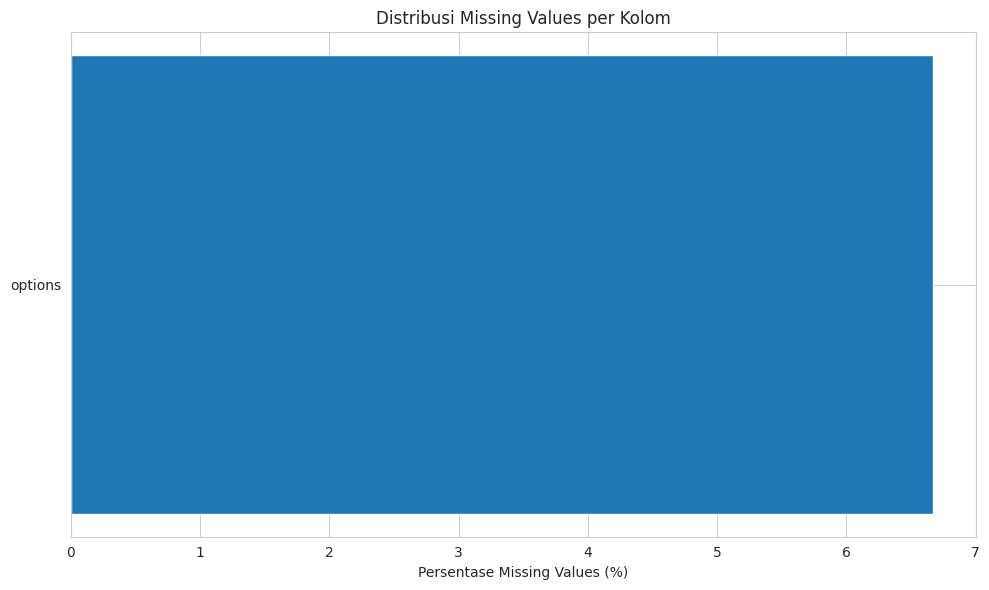

In [27]:
# Mengidentifikasi missing values
print("=" * 80)
print("ANALISIS MISSING VALUES")
print("=" * 80)

missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Kolom': missing_values.index,
    'Jumlah Missing': missing_values.values,
    'Persentase (%)': missing_percentage.values
})

print(missing_df[missing_df['Jumlah Missing'] > 0])

if missing_df['Jumlah Missing'].sum() == 0:
    print("\nTidak ditemukan missing values dalam dataset.")
else:
    print(f"\nTotal missing values: {missing_df['Jumlah Missing'].sum()}")

# Visualisasi missing values jika ada
if missing_df['Jumlah Missing'].sum() > 0:
    plt.figure(figsize=(10, 6))
    missing_cols = missing_df[missing_df['Jumlah Missing'] > 0]
    plt.barh(missing_cols['Kolom'], missing_cols['Persentase (%)'])
    plt.xlabel('Persentase Missing Values (%)')
    plt.title('Distribusi Missing Values per Kolom')
    plt.tight_layout()
    plt.show()

In [28]:
# Menangani missing values jika ada
# Strategi: Drop baris dengan missing values pada kolom penting (input dan output)
# karena kedua kolom ini essential untuk analisis sentimen

df_clean = df.copy()

if df_clean.isnull().sum().sum() > 0:
    # Drop baris yang memiliki missing values pada kolom input atau output
    initial_rows = len(df_clean)
    df_clean = df_clean.dropna(subset=['input', 'output'], how='any')
    dropped_rows = initial_rows - len(df_clean)

    print(f"Jumlah baris yang dihapus karena missing values: {dropped_rows}")
    print(f"Sisa data setelah penanganan missing values: {len(df_clean)} baris")
else:
    print("Tidak ada missing values yang perlu ditangani.")

# Verifikasi tidak ada lagi missing values
print(f"\nVerifikasi - Total missing values setelah cleaning: {df_clean.isnull().sum().sum()}")

Jumlah baris yang dihapus karena missing values: 0
Sisa data setelah penanganan missing values: 30000 baris

Verifikasi - Total missing values setelah cleaning: 2000


## 5. Identifikasi dan Penanganan Data Duplikat

Data duplikat dapat menyebabkan bias dalam analisis dan model. Kita perlu mengidentifikasi dan menghapus baris yang benar-benar duplikat.

In [29]:
# Mengidentifikasi duplikasi
print("=" * 80)
print("ANALISIS DATA DUPLIKAT")
print("=" * 80)

# Cek duplikasi pada semua kolom
duplicates_all = df_clean.duplicated().sum()
print(f"Jumlah baris duplikat (semua kolom): {duplicates_all}")

# Cek duplikasi spesifik pada kolom 'input' karena ini adalah text utama
duplicates_input = df_clean.duplicated(subset=['input']).sum()
print(f"Jumlah duplikasi pada kolom 'input': {duplicates_input}")

# Tampilkan contoh data duplikat jika ada
if duplicates_input > 0:
    print("\nContoh data duplikat (berdasarkan kolom 'input'):")
    duplicate_samples = df_clean[df_clean.duplicated(subset=['input'], keep=False)].sort_values('input').head(10)
    display(duplicate_samples[['input', 'output']])

ANALISIS DATA DUPLIKAT
Jumlah baris duplikat (semua kolom): 15001
Jumlah duplikasi pada kolom 'input': 17001

Contoh data duplikat (berdasarkan kolom 'input'):


,input,output
9543,I love them! Arf!!!! . So glad that I found them here as I can't find them in any of our sto...,A: very positive
14260,I love them! Arf!!!! . So glad that I found them here as I can't find them in any of our sto...,A: very positive
2163,Fuzzy Wuzzy's Summary:\n Highly recommended with warm fuzzies!\n\nCanon packages their macro ri...,A: very positive
13467,Fuzzy Wuzzy's Summary:\n Highly recommended with warm fuzzies!\n\nCanon packages their macro ri...,A: very positive
20695,"""Item as described. The Thera-band FlexBar arrived very quickly, it is a nice quality product an...",A: very positive
20364,"""Item as described. The Thera-band FlexBar arrived very quickly, it is a nice quality product an...",A: very positive
29681,"""Oh my gosh, amazing!"" - my 13 yr old daughter says. She wears contacts and is on the swim team...",A: very positive
24681,"""Oh my gosh, amazing!"" - my 13 yr old daughter says. She wears contacts and is on the swim team...",A: very positive
22681,"""Oh my gosh, amazing!"" - my 13 yr old daughter says. She wears contacts and is on the swim team...",A: very positive
25681,"""Oh my gosh, amazing!"" - my 13 yr old daughter says. She wears contacts and is on the swim team...",A: very positive


In [30]:
# Menghapus duplikasi
initial_rows = len(df_clean)

# Hapus duplikat berdasarkan kolom 'input', keep='first' untuk mempertahankan kemunculan pertama
df_clean = df_clean.drop_duplicates(subset=['input'], keep='first')

removed_duplicates = initial_rows - len(df_clean)

print(f"Jumlah baris duplikat yang dihapus: {removed_duplicates}")
print(f"Total data setelah menghapus duplikasi: {len(df_clean)} baris")

# Reset index setelah menghapus duplikasi
df_clean = df_clean.reset_index(drop=True)
print(f"Index berhasil direset.")

Jumlah baris duplikat yang dihapus: 17001
Total data setelah menghapus duplikasi: 12999 baris
Index berhasil direset.


## 6. Text Cleaning dan Preprocessing

Tahap ini melakukan pembersihan teks untuk memastikan data siap diproses oleh model. Proses ini menghapus noise seperti URL, HTML tags, karakter khusus, dan menormalisasi whitespace.

In [31]:
def advanced_text_cleaning(text):

    # Handle input yang bukan string
    if not isinstance(text, str):
        return str(text) if text is not None else ""

    # Hapus URL dengan pattern matching
    # Pattern ini menangkap URL yang dimulai dengan http://, https://, atau www.
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Hapus HTML tags menggunakan regex
    # Pattern <.*?> menangkap semua tag HTML
    text = re.sub(r'<.*?>', '', text)

    # Hapus karakter khusus, hanya pertahankan huruf (a-z, A-Z), angka (0-9), dan spasi
    # Ini membantu mengurangi dimensionalitas dan noise dalam data
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Normalisasi whitespace: ganti multiple spaces dengan single space
    # dan hapus leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


# Aplikasikan fungsi cleaning ke kolom 'input'
print("Memulai proses text cleaning...")
df_clean['cleaned_input'] = df_clean['input'].apply(advanced_text_cleaning)

# Tampilkan perbandingan sebelum dan sesudah cleaning
print("\n" + "=" * 80)
print("PERBANDINGAN TEKS SEBELUM DAN SESUDAH CLEANING")
print("=" * 80)

comparison_df = df_clean[['input', 'cleaned_input']].head()
for idx, row in comparison_df.iterrows():
    print(f"\n--- Sample {idx + 1} ---")
    print(f"Original  : {row['input'][:150]}...")
    print(f"Cleaned   : {row['cleaned_input'][:150]}...")

print(f"\nText cleaning selesai untuk {len(df_clean)} baris data.")

Memulai proses text cleaning...

PERBANDINGAN TEKS SEBELUM DAN SESUDAH CLEANING

--- Sample 1 ---
Original  : This is the second Sigg I've had. The first lasted 8 years or so before I finally dropped it one too many times and a hole got punched in the bottom. ...
Cleaned   : This is the second Sigg Ive had The first lasted 8 years or so before I finally dropped it one too many times and a hole got punched in the bottom I f...

--- Sample 2 ---
Original  : This was very good read. I really enjoyed the story plot as well country singer hireing his own personal  cook while on tour. I really enjoy the recip...
Cleaned   : This was very good read I really enjoyed the story plot as well country singer hireing his own personal cook while on tour I really enjoy the recipes ...

--- Sample 3 ---
Original  : Clock time would not set. Returned and received replacement. New one was able to set time initially. After short time the new one won't allow you to s...
Cleaned   : Clock time would not set

## 7. Ekstraksi dan Transformasi Label Sentimen

Pada tahap ini, kita mengekstrak label sentimen dari kolom output dan melakukan normalisasi kategori sentimen (menggabungkan 'very positive' dengan 'positive' dan 'very negative' dengan 'negative').

In [32]:
# Ekstraksi label sentimen dari kolom output
# Format awal: "A: very positive", "B: positive", dst.
# Kita hapus prefix (A:, B:, dst) untuk mendapatkan label yang bersih

df_clean['sentiment'] = df_clean['output'].str.replace(r'^[A-E]:\s*', '', regex=True)

print("=" * 80)
print("DISTRIBUSI SENTIMEN SEBELUM NORMALISASI")
print("=" * 80)
print(df_clean['sentiment'].value_counts())

# Normalisasi label sentimen
# Menggabungkan kategori yang sangat mirip untuk menyederhanakan klasifikasi
# very positive -> positive, very negative -> negative
sentiment_normalization = {
    'very positive': 'positive',
    'very negative': 'negative',
    'positive': 'positive',
    'negative': 'negative',
    'neutral': 'neutral'
}

df_clean['sentiment'] = df_clean['sentiment'].map(sentiment_normalization)

print("\n" + "=" * 80)
print("DISTRIBUSI SENTIMEN SETELAH NORMALISASI")
print("=" * 80)
print(df_clean['sentiment'].value_counts())
print("\nProporsi masing-masing kelas:")
print(df_clean['sentiment'].value_counts(normalize=True))

# Tampilkan sample hasil ekstraksi
print("\n" + "=" * 80)
print("SAMPLE HASIL EKSTRAKSI SENTIMEN")
print("=" * 80)
display(df_clean[['output', 'sentiment', 'cleaned_input']].head(10))

DISTRIBUSI SENTIMEN SEBELUM NORMALISASI
sentiment
very positive    7962
positive         2261
very negative    1183
neutral           979
negative          614
Name: count, dtype: int64

DISTRIBUSI SENTIMEN SETELAH NORMALISASI
sentiment
positive    10223
negative     1797
neutral       979
Name: count, dtype: int64

Proporsi masing-masing kelas:
sentiment
positive    0.786445
negative    0.138241
neutral     0.075313
Name: proportion, dtype: float64

SAMPLE HASIL EKSTRAKSI SENTIMEN


,output,sentiment,cleaned_input
0,A: very positive,positive,This is the second Sigg Ive had The first lasted 8 years or so before I finally dropped it one t...
1,A: very positive,positive,This was very good read I really enjoyed the story plot as well country singer hireing his own p...
2,E: very negative,negative,Clock time would not set Returned and received replacement New one was able to set time initiall...
3,B: positive,positive,This is a very good mp3 player I found it very workable and the sound quality is great Its just ...
4,A: very positive,positive,Another Benchmade another love story GREAT PRICE on Amazon I got a really good deal
5,B: positive,positive,This molding is paintable holds well and easy to install I ran it on my wall and ceiling to hide...
6,A: very positive,positive,The XF times adapter is well made as Ive compared with other similar adapters this one was one o...
7,A: very positive,positive,Since this type of exercise is coming back in style I was glad I was able to find one easily on ...
8,B: positive,positive,I use the USB reader to transfer photos from my Olympus D400 Zoom digital camera to my iMac Befo...
9,A: very positive,positive,Works great havent had any issues with this tray and have cooked with out about 5 times


## 8. Visualisasi Distribusi Sentimen

Visualisasi membantu kita memahami balance/imbalance dari kelas sentimen dalam dataset. Ini penting untuk menentukan apakah perlu dilakukan teknik balancing seperti oversampling atau undersampling.

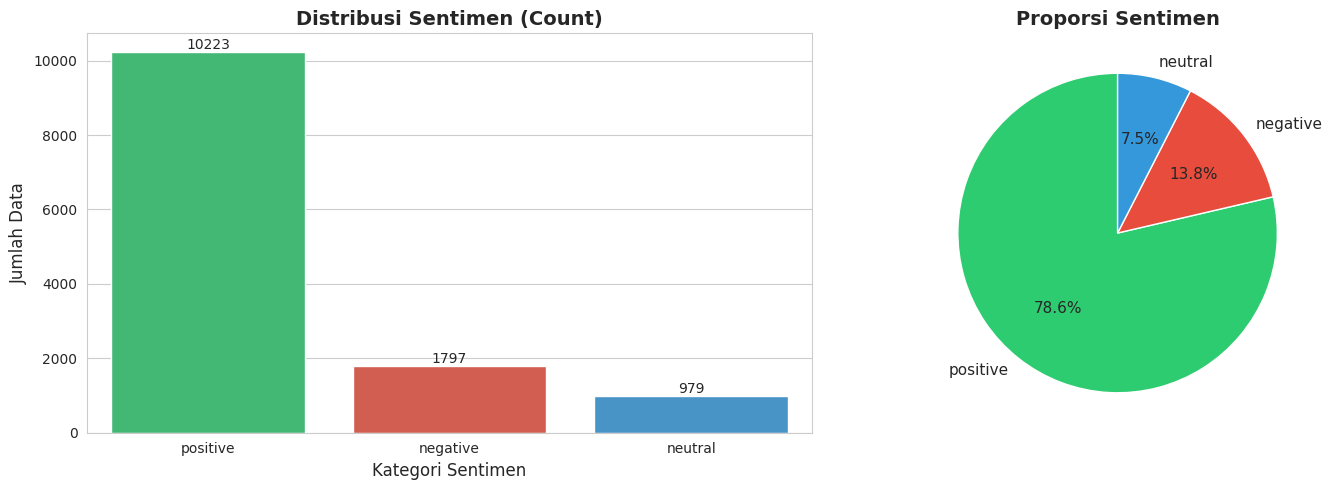


ANALISIS CLASS IMBALANCE
Kelas mayoritas: positive (10223 data)
Kelas minoritas: neutral (979 data)
Rasio imbalance: 10.44:1

⚠️  PERINGATAN: Dataset mengalami class imbalance yang signifikan!
   Rekomendasi: Gunakan teknik oversampling atau class weighting saat training model.


In [33]:
# Konfigurasi warna untuk setiap sentimen agar visualisasi lebih informatif
sentiment_colors = {
    'positive': '#2ecc71',  # Hijau untuk sentimen positif
    'negative': '#e74c3c',  # Merah untuk sentimen negatif
    'neutral': '#3498db'    # Biru untuk sentimen netral
}

# Membuat visualisasi distribusi sentimen
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Count plot
sns.countplot(
    x='sentiment',
    data=df_clean,
    hue='sentiment',
    palette=sentiment_colors,
    legend=False,
    ax=axes[0]
)
axes[0].set_title('Distribusi Sentimen (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Kategori Sentimen', fontsize=12)
axes[0].set_ylabel('Jumlah Data', fontsize=12)

# Tambahkan nilai di atas setiap bar
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d')

# Plot 2: Pie chart untuk proporsi
sentiment_counts = df_clean['sentiment'].value_counts()
colors = [sentiment_colors[label] for label in sentiment_counts.index]

axes[1].pie(
    sentiment_counts.values,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    textprops={'fontsize': 11}
)
axes[1].set_title('Proporsi Sentimen', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Analisis class imbalance
print("\n" + "=" * 80)
print("ANALISIS CLASS IMBALANCE")
print("=" * 80)
majority_class = sentiment_counts.idxmax()
minority_class = sentiment_counts.idxmin()
imbalance_ratio = sentiment_counts.max() / sentiment_counts.min()

print(f"Kelas mayoritas: {majority_class} ({sentiment_counts.max()} data)")
print(f"Kelas minoritas: {minority_class} ({sentiment_counts.min()} data)")
print(f"Rasio imbalance: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print("\n⚠️  PERINGATAN: Dataset mengalami class imbalance yang signifikan!")
    print("   Rekomendasi: Gunakan teknik oversampling atau class weighting saat training model.")
else:
    print("\n✓ Dataset relatif seimbang.")

## 9. Encoding Label Kategorikal

Machine learning model memerlukan input numerik. Oleh karena itu, kita perlu mengubah label sentimen kategorikal menjadi representasi numerik menggunakan label encoding.

In [34]:
# Definisi mapping untuk encoding sentimen
# Mapping ini konsisten dan akan digunakan sepanjang proses
sentiment_mapping = {
    'positive': 0,
    'neutral': 1,
    'negative': 2
}

# Aplikasikan encoding
df_clean['sentiment_encoded'] = df_clean['sentiment'].map(sentiment_mapping)

print("=" * 80)
print("SENTIMENT ENCODING MAPPING")
print("=" * 80)
for sentiment, code in sentiment_mapping.items():
    count = (df_clean['sentiment_encoded'] == code).sum()
    print(f"{sentiment:10s} -> {code} ({count:6d} data)")

print("\n" + "=" * 80)
print("SAMPLE DATA DENGAN ENCODED SENTIMEN")
print("=" * 80)
display(df_clean[['cleaned_input', 'sentiment', 'sentiment_encoded']].head(10))

# Verifikasi tidak ada missing values setelah encoding
assert df_clean['sentiment_encoded'].isnull().sum() == 0, "Terdapat nilai yang tidak termap dalam encoding!"
print("\n✓ Encoding berhasil, tidak ada nilai yang terlewat.")

SENTIMENT ENCODING MAPPING
positive   -> 0 ( 10223 data)
neutral    -> 1 (   979 data)
negative   -> 2 (  1797 data)

SAMPLE DATA DENGAN ENCODED SENTIMEN


,cleaned_input,sentiment,sentiment_encoded
0,This is the second Sigg Ive had The first lasted 8 years or so before I finally dropped it one t...,positive,0
1,This was very good read I really enjoyed the story plot as well country singer hireing his own p...,positive,0
2,Clock time would not set Returned and received replacement New one was able to set time initiall...,negative,2
3,This is a very good mp3 player I found it very workable and the sound quality is great Its just ...,positive,0
4,Another Benchmade another love story GREAT PRICE on Amazon I got a really good deal,positive,0
5,This molding is paintable holds well and easy to install I ran it on my wall and ceiling to hide...,positive,0
6,The XF times adapter is well made as Ive compared with other similar adapters this one was one o...,positive,0
7,Since this type of exercise is coming back in style I was glad I was able to find one easily on ...,positive,0
8,I use the USB reader to transfer photos from my Olympus D400 Zoom digital camera to my iMac Befo...,positive,0
9,Works great havent had any issues with this tray and have cooked with out about 5 times,positive,0



✓ Encoding berhasil, tidak ada nilai yang terlewat.


## 10. Analisis Panjang Teks

Sebelum split data, kita perlu memahami distribusi panjang teks. Ini membantu dalam menentukan parameter seperti max_length untuk tokenization.

STATISTIK PANJANG TEKS

Berdasarkan jumlah karakter:
count    12999.000000
mean       336.053466
std        421.637558
min         33.000000
25%        116.000000
50%        197.000000
75%        390.000000
max       7071.000000
Name: text_length_chars, dtype: float64

Berdasarkan jumlah kata:
count    12999.000000
mean        64.904685
std         80.083017
min          7.000000
25%         22.000000
50%         39.000000
75%         76.000000
max       1334.000000
Name: text_length_words, dtype: float64


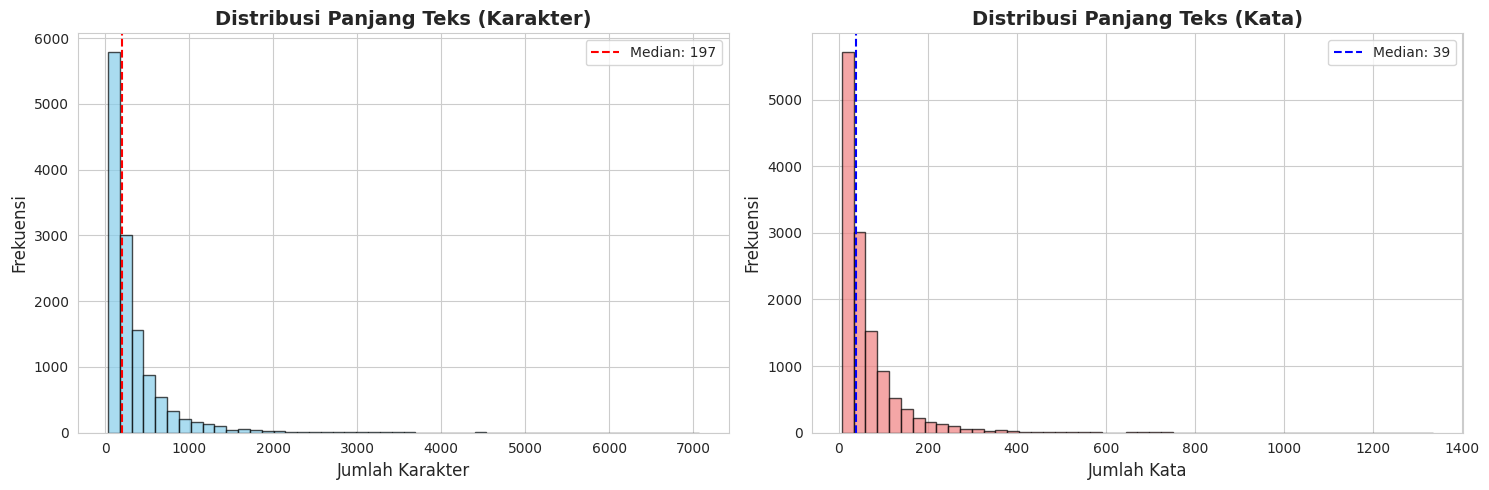

In [35]:
# Hitung panjang teks (jumlah karakter dan jumlah kata)
df_clean['text_length_chars'] = df_clean['cleaned_input'].str.len()
df_clean['text_length_words'] = df_clean['cleaned_input'].str.split().str.len()

print("=" * 80)
print("STATISTIK PANJANG TEKS")
print("=" * 80)
print("\nBerdasarkan jumlah karakter:")
print(df_clean['text_length_chars'].describe())

print("\nBerdasarkan jumlah kata:")
print(df_clean['text_length_words'].describe())

# Visualisasi distribusi panjang teks
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram panjang karakter
axes[0].hist(df_clean['text_length_chars'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df_clean['text_length_chars'].median(), color='red', linestyle='--',
                label=f"Median: {df_clean['text_length_chars'].median():.0f}")
axes[0].set_xlabel('Jumlah Karakter', fontsize=12)
axes[0].set_ylabel('Frekuensi', fontsize=12)
axes[0].set_title('Distribusi Panjang Teks (Karakter)', fontsize=14, fontweight='bold')
axes[0].legend()

# Histogram panjang kata
axes[1].hist(df_clean['text_length_words'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].axvline(df_clean['text_length_words'].median(), color='blue', linestyle='--',
                label=f"Median: {df_clean['text_length_words'].median():.0f}")
axes[1].set_xlabel('Jumlah Kata', fontsize=12)
axes[1].set_ylabel('Frekuensi', fontsize=12)
axes[1].set_title('Distribusi Panjang Teks (Kata)', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

## 11. Split Data: Training, Validation, dan Testing

Data split dilakukan dengan proporsi 70% training, 15% validation, dan 15% testing. Stratifikasi digunakan untuk memastikan distribusi sentimen yang konsisten di setiap set.

In [36]:
# Konstanta untuk reproducibility
RANDOM_STATE = 42
TEST_SIZE = 0.3  # 30% untuk gabungan validation + testing
VAL_TEST_SPLIT = 0.5  # 50% dari 30% = 15% untuk masing-masing validation dan testing

print("=" * 80)
print("PROSES SPLIT DATA")
print("=" * 80)

# Step 1: Split menjadi training (70%) dan temporary set (30%)
df_train, df_temp, _, _ = train_test_split(
    df_clean,
    df_clean['sentiment_encoded'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_clean['sentiment_encoded']
)

print(f"Step 1: Split data menjadi training (70%) dan temporary (30%)")
print(f"  - Training set: {len(df_train)} baris")
print(f"  - Temporary set: {len(df_temp)} baris")

# Step 2: Split temporary set menjadi validation (15%) dan testing (15%)
# test_size=0.5 karena 0.5 * 30% = 15% dari dataset original
df_val, df_test, _, _ = train_test_split(
    df_temp,
    df_temp['sentiment_encoded'],
    test_size=VAL_TEST_SPLIT,
    random_state=RANDOM_STATE,
    stratify=df_temp['sentiment_encoded']
)

print(f"\nStep 2: Split temporary set menjadi validation (15%) dan testing (15%)")
print(f"  - Validation set: {len(df_val)} baris")
print(f"  - Testing set: {len(df_test)} baris")

# Verifikasi proporsi
print("\n" + "=" * 80)
print("VERIFIKASI PROPORSI SPLIT")
print("=" * 80)
total_data = len(df_clean)
print(f"Total data original: {total_data}")
print(f"Training   : {len(df_train):6d} baris ({len(df_train)/total_data*100:.1f}%)")
print(f"Validation : {len(df_val):6d} baris ({len(df_val)/total_data*100:.1f}%)")
print(f"Testing    : {len(df_test):6d} baris ({len(df_test)/total_data*100:.1f}%)")
print(f"Total      : {len(df_train) + len(df_val) + len(df_test):6d} baris")

# Verifikasi stratifikasi - distribusi sentimen harus konsisten
print("\n" + "=" * 80)
print("VERIFIKASI STRATIFIKASI - DISTRIBUSI SENTIMEN")
print("=" * 80)

print("\nTraining Set:")
print(df_train['sentiment'].value_counts(normalize=True).sort_index())

print("\nValidation Set:")
print(df_val['sentiment'].value_counts(normalize=True).sort_index())

print("\nTesting Set:")
print(df_test['sentiment'].value_counts(normalize=True).sort_index())

print("\n✓ Stratifikasi berhasil - distribusi sentimen konsisten di setiap set.")

PROSES SPLIT DATA
Step 1: Split data menjadi training (70%) dan temporary (30%)
  - Training set: 9099 baris
  - Temporary set: 3900 baris

Step 2: Split temporary set menjadi validation (15%) dan testing (15%)
  - Validation set: 1950 baris
  - Testing set: 1950 baris

VERIFIKASI PROPORSI SPLIT
Total data original: 12999
Training   :   9099 baris (70.0%)
Validation :   1950 baris (15.0%)
Testing    :   1950 baris (15.0%)
Total      :  12999 baris

VERIFIKASI STRATIFIKASI - DISTRIBUSI SENTIMEN

Training Set:
sentiment
negative    0.138257
neutral     0.075283
positive    0.786460
Name: proportion, dtype: float64

Validation Set:
sentiment
negative    0.138462
neutral     0.075385
positive    0.786154
Name: proportion, dtype: float64

Testing Set:
sentiment
negative    0.137949
neutral     0.075385
positive    0.786667
Name: proportion, dtype: float64

✓ Stratifikasi berhasil - distribusi sentimen konsisten di setiap set.


## 12. Oversampling pada Training Set

Class imbalance dapat menyebabkan model bias terhadap kelas mayoritas. Untuk mengatasi ini, kita lakukan oversampling dengan teknik random sampling dengan replacement pada kelas minoritas.

**Catatan Penting**: Oversampling hanya dilakukan pada training set untuk mencegah data leakage. Validation dan testing set dibiarkan natural untuk evaluasi yang fair.

In [37]:
print("=" * 80)
print("OVERSAMPLING TRAINING SET")
print("=" * 80)

# Identifikasi kelas mayoritas dan jumlahnya
majority_count = df_train['sentiment'].value_counts().max()
majority_class = df_train['sentiment'].value_counts().idxmax()

print(f"Kelas mayoritas: {majority_class}")
print(f"Target jumlah per kelas: {majority_count} samples\n")

print("Distribusi SEBELUM oversampling:")
print(df_train['sentiment'].value_counts().sort_index())

# Inisialisasi dataframe untuk hasil oversampling
df_train_oversampled = pd.DataFrame()

# Lakukan oversampling untuk setiap kelas sentimen
for sentiment_label in df_train['sentiment'].unique():
    # Ambil data untuk sentimen tertentu
    sentiment_df = df_train[df_train['sentiment'] == sentiment_label]
    current_count = len(sentiment_df)

    if current_count < majority_count:
        # Kelas minoritas: lakukan oversampling dengan random sampling (replacement=True)
        # Ini akan menduplikasi beberapa sample secara random hingga mencapai jumlah mayoritas
        oversampled_df = sentiment_df.sample(
            n=majority_count,
            replace=True,
            random_state=RANDOM_STATE
        )
        print(f"  {sentiment_label:10s}: {current_count:5d} -> {len(oversampled_df):5d} samples (oversampled)")
    else:
        # Kelas mayoritas: gunakan semua data tanpa perubahan
        oversampled_df = sentiment_df
        print(f"  {sentiment_label:10s}: {current_count:5d} samples (unchanged)")

    # Gabungkan ke dataframe hasil
    df_train_oversampled = pd.concat([df_train_oversampled, oversampled_df], ignore_index=True)

# Shuffle data setelah oversampling untuk menghindari ordering bias
df_train_oversampled = df_train_oversampled.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print("\nDistribusi SETELAH oversampling:")
print(df_train_oversampled['sentiment'].value_counts().sort_index())

print("\n" + "=" * 80)
print("SUMMARY OVERSAMPLING")
print("=" * 80)
print(f"Ukuran training set sebelum oversampling: {len(df_train):6d} baris")
print(f"Ukuran training set setelah oversampling: {len(df_train_oversampled):6d} baris")
print(f"Peningkatan: {len(df_train_oversampled) - len(df_train):6d} baris ({(len(df_train_oversampled)/len(df_train) - 1)*100:.1f}%)")

print("\n✓ Oversampling selesai - semua kelas memiliki jumlah sample yang seimbang.")

OVERSAMPLING TRAINING SET
Kelas mayoritas: positive
Target jumlah per kelas: 7156 samples

Distribusi SEBELUM oversampling:
sentiment
negative    1258
neutral      685
positive    7156
Name: count, dtype: int64
  positive  :  7156 samples (unchanged)
  neutral   :   685 ->  7156 samples (oversampled)
  negative  :  1258 ->  7156 samples (oversampled)

Distribusi SETELAH oversampling:
sentiment
negative    7156
neutral     7156
positive    7156
Name: count, dtype: int64

SUMMARY OVERSAMPLING
Ukuran training set sebelum oversampling:   9099 baris
Ukuran training set setelah oversampling:  21468 baris
Peningkatan:  12369 baris (135.9%)

✓ Oversampling selesai - semua kelas memiliki jumlah sample yang seimbang.


## 13. Visualisasi Perbandingan Sebelum dan Sesudah Oversampling

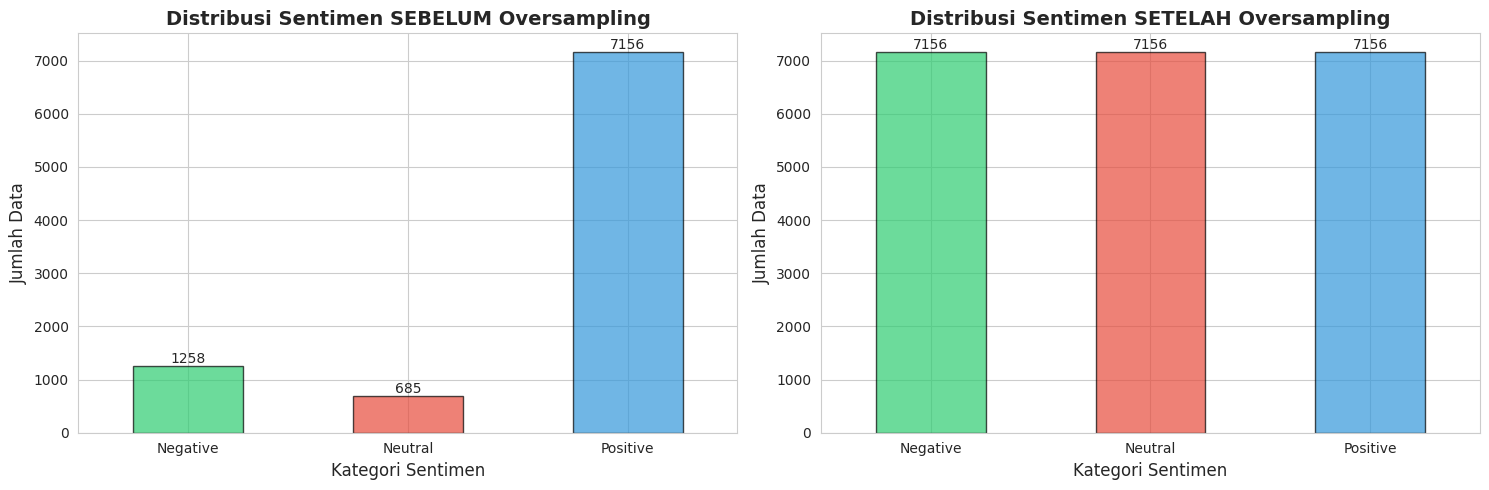

In [38]:
# Membuat visualisasi perbandingan
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot sebelum oversampling
df_train['sentiment'].value_counts().sort_index().plot(
    kind='bar',
    ax=axes[0],
    color=['#2ecc71', '#e74c3c', '#3498db'],
    edgecolor='black',
    alpha=0.7
)
axes[0].set_title('Distribusi Sentimen SEBELUM Oversampling', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Kategori Sentimen', fontsize=12)
axes[0].set_ylabel('Jumlah Data', fontsize=12)
axes[0].set_xticklabels(['Negative', 'Neutral', 'Positive'], rotation=0)

# Tambahkan nilai di atas bar
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d')

# Plot setelah oversampling
df_train_oversampled['sentiment'].value_counts().sort_index().plot(
    kind='bar',
    ax=axes[1],
    color=['#2ecc71', '#e74c3c', '#3498db'],
    edgecolor='black',
    alpha=0.7
)
axes[1].set_title('Distribusi Sentimen SETELAH Oversampling', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Kategori Sentimen', fontsize=12)
axes[1].set_ylabel('Jumlah Data', fontsize=12)
axes[1].set_xticklabels(['Negative', 'Neutral', 'Positive'], rotation=0)

# Tambahkan nilai di atas bar
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

## 14. Tokenisasi dengan BERT Tokenizer

Untuk model berbasis transformer seperti BERT, kita perlu mengubah teks menjadi token numerik. Proses ini menggunakan pre-trained BERT tokenizer yang sudah dilatih pada vocabulary yang luas.

In [39]:
# Load pre-trained BERT tokenizer
# bert-base-uncased: versi BERT dengan lowercase text
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

print("=" * 80)
print("BERT TOKENIZER")
print("=" * 80)
print(f"Model tokenizer: bert-base-uncased")
print(f"Vocabulary size: {tokenizer.vocab_size:,} tokens")
print(f"Model max length: {tokenizer.model_max_length} tokens")
print("\n✓ BERT Tokenizer berhasil dimuat.")

BERT TOKENIZER
Model tokenizer: bert-base-uncased
Vocabulary size: 30,522 tokens
Model max length: 512 tokens

✓ BERT Tokenizer berhasil dimuat.


## 15. Analisis Distribusi Panjang Token

Sebelum menentukan max_length untuk tokenization, kita perlu menganalisis distribusi panjang token dalam data. Ini membantu kita menemukan nilai optimal yang bisa menangani sebagian besar data tanpa terlalu banyak padding.

Menghitung panjang token untuk analisis distribusi...
Selesai menghitung 21468 samples.

STATISTIK PANJANG TOKEN
Minimum      : 10 tokens
Maksimum     : 512 tokens
Mean         : 75.73 tokens
Median       : 47 tokens
Std Dev      : 80.49 tokens
Percentile 90: 162 tokens
Percentile 95: 229 tokens
Percentile 99: 455 tokens


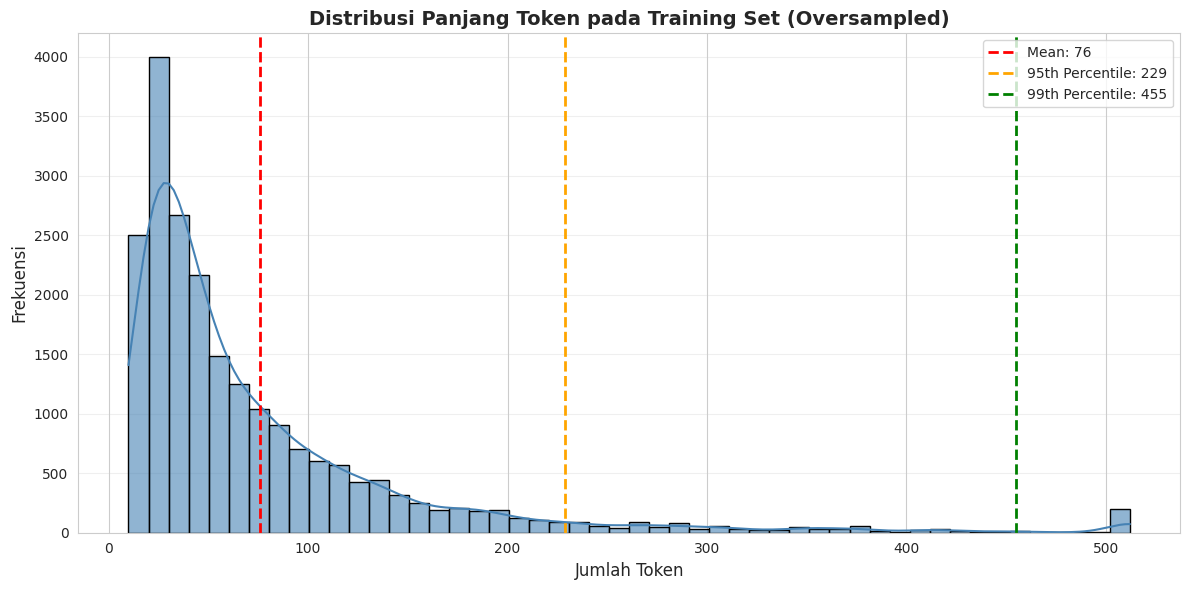


PENENTUAN MAX_LENGTH
Suggested max_length (95th percentile): 229 tokens
Chosen MAX_LENGTH: 229 tokens
Coverage: ~95.0% dari data


In [40]:
# Hitung panjang token untuk setiap teks dalam training set yang sudah di-oversample
# Kita gunakan truncation di sini hanya untuk analisis, bukan untuk tokenization final
print("Menghitung panjang token untuk analisis distribusi...")

token_lengths = [
    len(tokenizer.encode(
        str(text),
        add_special_tokens=True,
        truncation=True,
        max_length=tokenizer.model_max_length
    ))
    for text in df_train_oversampled['cleaned_input']
]

print(f"Selesai menghitung {len(token_lengths)} samples.\n")

# Statistik deskriptif
print("=" * 80)
print("STATISTIK PANJANG TOKEN")
print("=" * 80)
print(f"Minimum      : {np.min(token_lengths)} tokens")
print(f"Maksimum     : {np.max(token_lengths)} tokens")
print(f"Mean         : {np.mean(token_lengths):.2f} tokens")
print(f"Median       : {np.median(token_lengths):.0f} tokens")
print(f"Std Dev      : {np.std(token_lengths):.2f} tokens")
print(f"Percentile 90: {np.percentile(token_lengths, 90):.0f} tokens")
print(f"Percentile 95: {np.percentile(token_lengths, 95):.0f} tokens")
print(f"Percentile 99: {np.percentile(token_lengths, 99):.0f} tokens")

# Visualisasi distribusi
plt.figure(figsize=(12, 6))
sns.histplot(token_lengths, bins=50, kde=True, color='steelblue', edgecolor='black', alpha=0.6)

# Tambahkan garis vertikal untuk statistik penting
plt.axvline(np.mean(token_lengths), color='red', linestyle='--',
            label=f'Mean: {np.mean(token_lengths):.0f}', linewidth=2)
plt.axvline(np.percentile(token_lengths, 95), color='orange', linestyle='--',
            label=f'95th Percentile: {np.percentile(token_lengths, 95):.0f}', linewidth=2)
plt.axvline(np.percentile(token_lengths, 99), color='green', linestyle='--',
            label=f'99th Percentile: {np.percentile(token_lengths, 99):.0f}', linewidth=2)

plt.xlabel('Jumlah Token', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.title('Distribusi Panjang Token pada Training Set (Oversampled)',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Tentukan MAX_LENGTH optimal
# Kita gunakan percentile 95 atau 99 untuk coverage yang baik tanpa terlalu banyak padding
# Namun tetap dibatasi maksimal 512 (limit BERT)
suggested_max_length = int(np.percentile(token_lengths, 95))
MAX_LENGTH = min(suggested_max_length, 512)

# Untuk efisiensi, kita bisa set ke nilai yang lebih reasonable jika terlalu panjang
if MAX_LENGTH > 400:
    MAX_LENGTH = 330  # Nilai praktis yang masih cover majority data

print("\n" + "=" * 80)
print("PENENTUAN MAX_LENGTH")
print("=" * 80)
print(f"Suggested max_length (95th percentile): {suggested_max_length} tokens")
print(f"Chosen MAX_LENGTH: {MAX_LENGTH} tokens")
print(f"Coverage: ~{(np.array(token_lengths) <= MAX_LENGTH).sum() / len(token_lengths) * 100:.1f}% dari data")

## 16. Tokenisasi Final pada Semua Dataset Split

Dengan MAX_LENGTH yang sudah ditentukan, kita lakukan tokenisasi pada training, validation, dan testing set. Proses ini mengkonversi teks menjadi format yang siap digunakan oleh model BERT.

In [41]:
def tokenize_data(texts, tokenizer, max_length):
    """
    Fungsi untuk melakukan tokenisasi pada sekumpulan teks.

    Parameters:
    -----------
    texts : Series/List
        Koleksi teks yang akan ditokenisasi
    tokenizer : PreTrainedTokenizer
        BERT tokenizer
    max_length : int
        Panjang maksimal sequence setelah tokenization

    Returns:
    --------
    BatchEncoding
        Dictionary berisi input_ids, attention_mask, dan token_type_ids dalam format PyTorch tensor

    Process:
    --------
    - padding='max_length': Tambahkan padding hingga max_length
    - truncation=True: Potong teks yang melebihi max_length
    - return_tensors='pt': Return dalam format PyTorch tensor
    """
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )


print("=" * 80)
print("TOKENISASI DATASET")
print("=" * 80)

# Tokenisasi training set (yang sudah di-oversample)
print("Melakukan tokenisasi pada training set (oversampled)...")
X_train_tokenized = tokenize_data(df_train_oversampled['cleaned_input'], tokenizer, MAX_LENGTH)
print(f"  ✓ Selesai - Shape: {X_train_tokenized['input_ids'].shape}")

# Tokenisasi validation set
print("Melakukan tokenisasi pada validation set...")
X_val_tokenized = tokenize_data(df_val['cleaned_input'], tokenizer, MAX_LENGTH)
print(f"  ✓ Selesai - Shape: {X_val_tokenized['input_ids'].shape}")

# Tokenisasi testing set
print("Melakukan tokenisasi pada testing set...")
X_test_tokenized = tokenize_data(df_test['cleaned_input'], tokenizer, MAX_LENGTH)
print(f"  ✓ Selesai - Shape: {X_test_tokenized['input_ids'].shape}")

print("\n" + "=" * 80)
print("SUMMARY TOKENISASI")
print("=" * 80)
print(f"MAX_LENGTH yang digunakan: {MAX_LENGTH} tokens")
print(f"\nTraining set   : {X_train_tokenized['input_ids'].shape[0]:6d} samples × {MAX_LENGTH} tokens")
print(f"Validation set : {X_val_tokenized['input_ids'].shape[0]:6d} samples × {MAX_LENGTH} tokens")
print(f"Testing set    : {X_test_tokenized['input_ids'].shape[0]:6d} samples × {MAX_LENGTH} tokens")

print("\n✓ Tokenisasi berhasil untuk semua dataset split.")

TOKENISASI DATASET
Melakukan tokenisasi pada training set (oversampled)...
  ✓ Selesai - Shape: torch.Size([21468, 229])
Melakukan tokenisasi pada validation set...
  ✓ Selesai - Shape: torch.Size([1950, 229])
Melakukan tokenisasi pada testing set...
  ✓ Selesai - Shape: torch.Size([1950, 229])

SUMMARY TOKENISASI
MAX_LENGTH yang digunakan: 229 tokens

Training set   :  21468 samples × 229 tokens
Validation set :   1950 samples × 229 tokens
Testing set    :   1950 samples × 229 tokens

✓ Tokenisasi berhasil untuk semua dataset split.


## 17. Data Dictionary

Data dictionary menjelaskan setiap variabel/kolom dalam dataset yang sudah diproses, termasuk tipe data, deskripsi, dan contoh nilai.

In [42]:
# Membuat data dictionary
data_dictionary = {
    'Nama Kolom': [
        'input',
        'output',
        'cleaned_input',
        'sentiment',
        'sentiment_encoded',
        'text_length_chars',
        'text_length_words'
    ],
    'Tipe Data': [
        'object (string)',
        'object (string)',
        'object (string)',
        'object (string)',
        'int64',
        'int64',
        'int64'
    ],
    'Deskripsi': [
        'Teks input original dari dataset sebelum preprocessing',
        'Label output original dengan format prefix (A:, B:, dst) dan kategori sentimen',
        'Teks input yang sudah dibersihkan dari URL, HTML tags, karakter khusus, dan whitespace yang tidak perlu',
        'Label sentimen kategorikal hasil ekstraksi dan normalisasi (positive, negative, neutral)',
        'Label sentimen dalam format numerik untuk keperluan machine learning (0: positive, 1: neutral, 2: negative)',
        'Jumlah karakter dalam teks yang sudah dibersihkan',
        'Jumlah kata dalam teks yang sudah dibersihkan'
    ],
    'Contoh Nilai': [
        'Check out this amazing product! http://example.com',
        'A: very positive',
        'Check out this amazing product',
        'positive',
        '0',
        '34',
        '5'
    ],
    'Missing Values': [
        '0',
        '0',
        '0',
        '0',
        '0',
        '0',
        '0'
    ]
}

df_dictionary = pd.DataFrame(data_dictionary)

print("=" * 80)
print("DATA DICTIONARY - DATASET PREPROCESSING")
print("=" * 80)
display(df_dictionary)


DATA DICTIONARY - DATASET PREPROCESSING


,Nama Kolom,Tipe Data,Deskripsi,Contoh Nilai,Missing Values
0,input,object (string),Teks input original dari dataset sebelum preprocessing,Check out this amazing product! http://example.com,0
1,output,object (string),"Label output original dengan format prefix (A:, B:, dst) dan kategori sentimen",A: very positive,0
2,cleaned_input,object (string),"Teks input yang sudah dibersihkan dari URL, HTML tags, karakter khusus, dan whitespace yang tida...",Check out this amazing product,0
3,sentiment,object (string),"Label sentimen kategorikal hasil ekstraksi dan normalisasi (positive, negative, neutral)",positive,0
4,sentiment_encoded,int64,"Label sentimen dalam format numerik untuk keperluan machine learning (0: positive, 1: neutral, 2...",0,0
5,text_length_chars,int64,Jumlah karakter dalam teks yang sudah dibersihkan,34,0
6,text_length_words,int64,Jumlah kata dalam teks yang sudah dibersihkan,5,0


## 18. Summary dan Hasil Akhir Preprocessing

Ringkasan lengkap dari semua proses preprocessing yang telah dilakukan, termasuk statistik dataset dan output yang dihasilkan.

In [43]:
print("=" * 80)
print("LAPORAN AKHIR DATA WRANGLING DAN PREPROCESSING")
print("=" * 80)

print("\n📊 STATISTIK DATASET")
print("-" * 80)
print(f"Dataset original          : {len(df):,} baris")
print(f"Baris duplikat dihapus    : {removed_duplicates:,} baris")
print(f"Dataset setelah cleaning  : {len(df_clean):,} baris")
print(f"Missing values ditangani  : Ya (drop baris dengan missing values pada kolom penting)")

print("\n📂 DATA SPLIT")
print("-" * 80)
print(f"Training set (original)   : {len(df_train):,} baris (70%)")
print(f"Training set (oversampled): {len(df_train_oversampled):,} baris")
print(f"Validation set            : {len(df_val):,} baris (15%)")
print(f"Testing set               : {len(df_test):,} baris (15%)")

print("\n🔄 TRANSFORMASI")
print("-" * 80)
print(f"Text cleaning             : ✓ Selesai")
print(f"Label encoding            : ✓ Selesai (3 kelas)")
print(f"Oversampling              : ✓ Selesai (balance ratio 1:1:1)")
print(f"Tokenization              : ✓ Selesai (BERT, max_length={MAX_LENGTH})")
print(f"Tensor conversion         : ✓ Selesai (PyTorch tensors)")

print("\n📈 DISTRIBUSI SENTIMEN (Training Set Oversampled)")
print("-" * 80)
for sentiment in ['negative', 'neutral', 'positive']:
    count = (df_train_oversampled['sentiment'] == sentiment).sum()
    percentage = count / len(df_train_oversampled) * 100
    print(f"{sentiment.capitalize():10s}: {count:6,} samples ({percentage:5.1f}%)")

print("\n✅ OUTPUT YANG DIHASILKAN")
print("-" * 80)
outputs = [
    "1. Dataset bersih (df_clean): Dataset yang sudah melalui cleaning, handling missing values, dan transformasi",
    "2. Training set (df_train_oversampled): Data training yang sudah di-balance dengan oversampling",
    "3. Validation set (df_val): Data untuk validasi model selama training",
    "4. Testing set (df_test): Data untuk evaluasi performa final model",
    "5. PyTorch DataLoaders: train_dataloader, val_dataloader, test_dataloader siap untuk model training",
    "6. Data Dictionary: Dokumentasi lengkap setiap variabel dalam dataset",
    "7. Laporan Preprocessing: Dokumentasi semua tahapan dan hasil preprocessing"
]

for output in outputs:
    print(f"  {output}")

print("\n" + "=" * 80)
print("PREPROCESSING SELESAI - DATASET SIAP UNTUK MODEL TRAINING")
print("=" * 80)

LAPORAN AKHIR DATA WRANGLING DAN PREPROCESSING

📊 STATISTIK DATASET
--------------------------------------------------------------------------------
Dataset original          : 30,000 baris
Baris duplikat dihapus    : 17,001 baris
Dataset setelah cleaning  : 12,999 baris
Missing values ditangani  : Ya (drop baris dengan missing values pada kolom penting)

📂 DATA SPLIT
--------------------------------------------------------------------------------
Training set (original)   : 9,099 baris (70%)
Training set (oversampled): 21,468 baris
Validation set            : 1,950 baris (15%)
Testing set               : 1,950 baris (15%)

🔄 TRANSFORMASI
--------------------------------------------------------------------------------
Text cleaning             : ✓ Selesai
Label encoding            : ✓ Selesai (3 kelas)
Oversampling              : ✓ Selesai (balance ratio 1:1:1)
Tokenization              : ✓ Selesai (BERT, max_length=229)
Tensor conversion         : ✓ Selesai (PyTorch tensors)

📈 DISTRI

## 18. Ekspor Dataset Bersih (Opsional)

Menyimpan dataset yang sudah dibersihkan untuk keperluan dokumentasi atau analisis lebih lanjut.

In [44]:
# Simpan dataset bersih ke CSV (opsional)
output_filename = 'sentiment_dataset_cleaned.csv'

# Pilih kolom yang relevan untuk disimpan
columns_to_save = [
    'input',
    'output',
    'cleaned_input',
    'sentiment',
    'sentiment_encoded',
    'text_length_chars',
    'text_length_words'
]

df_clean[columns_to_save].to_csv(output_filename, index=False)

print(f"✓ Dataset bersih berhasil disimpan ke: {output_filename}")
print(f"  Total baris: {len(df_clean):,}")
print(f"  Total kolom: {len(columns_to_save)}")

✓ Dataset bersih berhasil disimpan ke: sentiment_dataset_cleaned.csv
  Total baris: 12,999
  Total kolom: 7


In [45]:
# Ekspor dataset dengan tokenization results ke CSV
print("=" * 80)
print("EKSPOR DATASET DENGAN TOKENIZATION RESULTS")
print("=" * 80)

# Fungsi helper untuk convert tensor ke string representation
def tensor_to_string(tensor):
  """Convert PyTorch tensor to comma-separated string"""
  return ','.join(map(str, tensor.tolist()))

# Prepare data untuk export - Training Set
print("\nMemproses training set...")
export_train = pd.DataFrame({
  'cleaned_input': df_train_oversampled['cleaned_input'].values,
  'sentiment': df_train_oversampled['sentiment'].values,
  'sentiment_encoded': df_train_oversampled['sentiment_encoded'].values,
  'input_ids': [tensor_to_string(input_ids_train[i]) for i in range(len(input_ids_train))],
  'attention_mask': [tensor_to_string(attention_mask_train[i]) for i in range(len(attention_mask_train))]
})

# Prepare data untuk export - Validation Set
print("Memproses validation set...")
export_val = pd.DataFrame({
  'cleaned_input': df_val['cleaned_input'].values,
  'sentiment': df_val['sentiment'].values,
  'sentiment_encoded': df_val['sentiment_encoded'].values,
  'input_ids': [tensor_to_string(input_ids_val[i]) for i in range(len(input_ids_val))],
  'attention_mask': [tensor_to_string(attention_mask_val[i]) for i in range(len(attention_mask_val))]
})

# Prepare data untuk export - Testing Set
print("Memproses testing set...")
export_test = pd.DataFrame({
  'cleaned_input': df_test['cleaned_input'].values,
  'sentiment': df_test['sentiment'].values,
  'sentiment_encoded': df_test['sentiment_encoded'].values,
  'input_ids': [tensor_to_string(input_ids_test[i]) for i in range(len(input_ids_test))],
  'attention_mask': [tensor_to_string(attention_mask_test[i]) for i in range(len(attention_mask_test))]
})

# Export ke CSV files
train_filename = 'sentiment_train_tokenized.csv'
val_filename = 'sentiment_val_tokenized.csv'
test_filename = 'sentiment_test_tokenized.csv'

print("\nMenyimpan file CSV...")
export_train.to_csv(train_filename, index=False)
print(f"✓ Training set disimpan: {train_filename} ({len(export_train):,} baris)")

export_val.to_csv(val_filename, index=False)
print(f"✓ Validation set disimpan: {val_filename} ({len(export_val):,} baris)")

export_test.to_csv(test_filename, index=False)
print(f"✓ Testing set disimpan: {test_filename} ({len(export_test):,} baris)")

print("\n" + "=" * 80)
print("SUMMARY EXPORT")
print("=" * 80)
print(f"Total file CSV yang dibuat: 3 files")
print(f"Kolom dalam setiap file: {list(export_train.columns)}")
print(f"\nCatatan:")
print("- input_ids dan attention_mask disimpan sebagai comma-separated string")
print("- Setiap row berisi {MAX_LENGTH} token values")
print("- File dapat dimuat kembali dengan parsing string ke list/tensor")

# Tampilkan sample data
print("\n" + "=" * 80)
print("SAMPLE DATA (Training Set - 3 baris pertama)")
print("=" * 80)
display(export_train[['cleaned_input', 'sentiment', 'sentiment_encoded']].head(3))
print("\nContoh input_ids (20 token pertama dari baris pertama):")
print(export_train['input_ids'].iloc[0][:200] + "...")

EKSPOR DATASET DENGAN TOKENIZATION RESULTS

Memproses training set...
Memproses validation set...
Memproses testing set...

Menyimpan file CSV...
✓ Training set disimpan: sentiment_train_tokenized.csv (21,468 baris)
✓ Validation set disimpan: sentiment_val_tokenized.csv (1,950 baris)
✓ Testing set disimpan: sentiment_test_tokenized.csv (1,950 baris)

SUMMARY EXPORT
Total file CSV yang dibuat: 3 files
Kolom dalam setiap file: ['cleaned_input', 'sentiment', 'sentiment_encoded', 'input_ids', 'attention_mask']

Catatan:
- input_ids dan attention_mask disimpan sebagai comma-separated string
- Setiap row berisi {MAX_LENGTH} token values
- File dapat dimuat kembali dengan parsing string ke list/tensor

SAMPLE DATA (Training Set - 3 baris pertama)


,cleaned_input,sentiment,sentiment_encoded
0,Profile Gauge The pins on this are not too thin and not too stiff You can use it on a six inch w...,positive,0
1,It doesnt whistle You have to pay attention to the cooker all the time You have to just randomly...,negative,2
2,i am very pleased with this roaster i bought it so i would have something deep enough to roast a...,positive,0



Contoh input_ids (20 token pertama dari baris pertama):
101,6337,7633,1996,16300,2006,2023,2024,2025,2205,4857,1998,2025,2205,10551,2017,2064,2224,2009,2006,1037,2416,4960,2898,3538,1997,3536,6198,1998,2059,7637,2009,3031,22160,2102,3259,1998,2009,2987,210...
